In [1]:
import sys
import os
import subprocess
import re
import numpy as np
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as psql
import getpass
import matplotlib as mpl
import argparse
import glob
import traceback
import hashlib
import math
import collections
import functools

mpl.rcParams['figure.dpi'] = 80

import matplotlib.pyplot as plt
import seaborn as sns

app_base_dir = '/home/spbproc/euso-spb-patt-reco-v1'
if app_base_dir not in sys.path:
    sys.path.append(app_base_dir)

import event_processing_v3
import event_processing_v4
import postgresql_v3_event_storage
import dataset_query_functions_v3

import tool.acqconv
from data_analysis_utils import *
from data_analysis_utils_performance import *
# import supervised_classification as supc    
from utility_funtions import key_vals2val_keys

from sklearn.externals import joblib

Welcome to JupyROOT 6.13/02


In [2]:
data_snippets_dir = 'trigger_rate_figures_flatmap_bgf05_20190531'
os.makedirs(data_snippets_dir, exist_ok=True)
os.makedirs(os.path.join(data_snippets_dir, 'figures'), exist_ok=True)

In [3]:
event_processing_cls = event_processing_v4.EventProcessingV4
event_v3_storage_provider_flight = dataset_query_functions_v3.build_event_v3_storage_provider(
    event_storage_provider_config_file=os.path.join(app_base_dir,'config_w_flatmap.ini'), 
    table_names_version='ver4',
    event_storage_class=postgresql_v3_event_storage.PostgreSqlEventV3StorageProvider,
    event_processing_class=event_processing_cls
)

query_functions_flight = dataset_query_functions_v3.Ver3DatasetQueryFunctions(event_v3_storage_provider_flight)

In [4]:
common_included_columns_re_list = [
  ('^$','source_file_(acquisition|trigger)(_full)?|global_gtu|packet_id|gtu_in_packet|event_id|num_gtu'),
  
  'gtu_datetime_(mean|min|max)',  
  'gps_datetime_(mean|min|max)', 'gps_alt_mean', 'gps_lon_mean', 'gps_lat_mean', 
    
  ('^trg(_box_per_gtu|_pmt_per_gtu|_ec_per_gtu)?$', '^(count_nonzero|min|max|sum|mean|size)$'),
  ('^(bg|orig)(_x_y)?$','^(mean_gz|mean|max|min|sum)$'),
    
#   '(proc\d|trg|alt\d)_(x|gtu)_(x|y)_hough_peak_thr2_max_clu_major_line_phi',
    
]

In [5]:
flight_columns_for_analysis_dict = query_functions_flight.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=('^.+$',),
    default_excluded_columns_re_list=[],
    included_columns_re_list=common_included_columns_re_list
)

print_columns_dict(flight_columns_for_analysis_dict)

spb_processing_v4_flatmap.event
	- event_id
	- source_file_acquisition_full
	- source_file_trigger_full
	- source_file_acquisition
	- source_file_trigger
	- global_gtu
	- packet_id
	- gtu_in_packet
	- num_gtu

spb_processing_v4_flatmap.event_trg_box_per_gtu
	- max
	- min
	- sum
	- mean

spb_processing_v4_flatmap.event_trg_pmt_per_gtu
	- max
	- min
	- sum
	- mean

spb_processing_v4_flatmap.event_trg_ec_per_gtu
	- max
	- min
	- sum
	- mean

spb_processing_v4_flatmap.event_gps_lat
	- mean

spb_processing_v4_flatmap.event_gps_lon
	- mean

spb_processing_v4_flatmap.event_gps_alt
	- mean

spb_processing_v4_flatmap.event_gps_datetime
	- max
	- min
	- mean

spb_processing_v4_flatmap.event_gtu_datetime
	- max
	- min
	- mean

spb_processing_v4_flatmap.event_orig_x_y
	- sum
	- min
	- max
	- mean
	- mean_gz

spb_processing_v4_flatmap.event_bg_x_y
	- sum
	- min
	- max
	- mean
	- mean_gz

spb_processing_v4_flatmap.event_trg
	- count_nonzero
	- sum
	- min
	- max
	- mean
	- size

spb_processing_v4_fla

In [6]:
flight_df_columns = query_functions_flight.get_dataframe_columns_from_dict(flight_columns_for_analysis_dict)

In [7]:
# not in the report
current_columns_for_analysis_dict = flight_columns_for_analysis_dict

unl_flight_select_clause_str, unl_flight_tables_list = \
    query_functions_flight.get_query_clauses__select(current_columns_for_analysis_dict)

unl_flight_clauses_str = \
    query_functions_flight.get_query_clauses__join(unl_flight_tables_list)

unl_source_data_type_num = 1

unl_flight_where_clauses_str = ''' 
''' 

unl_flight_events_selection_query = \
    query_functions_flight.get_events_selection_query_plain(
        source_data_type_num=unl_source_data_type_num,
        select_additional=unl_flight_select_clause_str, 
        join_additional=unl_flight_clauses_str,
        where_additional=unl_flight_where_clauses_str,
        order_by='{data_table_name}.event_id', 
        offset=0, 
#         limit=20000,                            # intentionally selecting incomplete subset to save memory !!!!!!!!!!!!!
        limit=500000,
        base_select='')

print(unl_flight_events_selection_query)


    SELECT 
        
        spb_processing_v4_flatmap.event.event_id, spb_processing_v4_flatmap.event.source_file_acquisition_full, spb_processing_v4_flatmap.event.source_file_trigger_full, spb_processing_v4_flatmap.event.source_file_acquisition, spb_processing_v4_flatmap.event.source_file_trigger, spb_processing_v4_flatmap.event.global_gtu, spb_processing_v4_flatmap.event.packet_id, spb_processing_v4_flatmap.event.gtu_in_packet, spb_processing_v4_flatmap.event.num_gtu, spb_processing_v4_flatmap.event_trg_box_per_gtu.max AS trg_box_per_gtu_max, spb_processing_v4_flatmap.event_trg_box_per_gtu.min AS trg_box_per_gtu_min, spb_processing_v4_flatmap.event_trg_box_per_gtu.sum AS trg_box_per_gtu_sum, spb_processing_v4_flatmap.event_trg_box_per_gtu.mean AS trg_box_per_gtu_mean, spb_processing_v4_flatmap.event_trg_pmt_per_gtu.max AS trg_pmt_per_gtu_max, spb_processing_v4_flatmap.event_trg_pmt_per_gtu.min AS trg_pmt_per_gtu_min, spb_processing_v4_flatmap.event_trg_pmt_per_gtu.sum AS trg_pmt_pe

In [8]:
unl_flight_df = psql.read_sql(unl_flight_events_selection_query, event_v3_storage_provider_flight.connection)
# flight_df = psql.read_sql(flight_events_selection_query, event_v3_storage_provider_flight.connection)

In [9]:
len(unl_flight_df)

243622

In [10]:
flight_df_columns

['event_id',
 'source_file_acquisition_full',
 'source_file_trigger_full',
 'source_file_acquisition',
 'source_file_trigger',
 'global_gtu',
 'packet_id',
 'gtu_in_packet',
 'num_gtu',
 'trg_box_per_gtu_max',
 'trg_box_per_gtu_min',
 'trg_box_per_gtu_sum',
 'trg_box_per_gtu_mean',
 'trg_pmt_per_gtu_max',
 'trg_pmt_per_gtu_min',
 'trg_pmt_per_gtu_sum',
 'trg_pmt_per_gtu_mean',
 'trg_ec_per_gtu_max',
 'trg_ec_per_gtu_min',
 'trg_ec_per_gtu_sum',
 'trg_ec_per_gtu_mean',
 'gps_lat_mean',
 'gps_lon_mean',
 'gps_alt_mean',
 'gps_datetime_max',
 'gps_datetime_min',
 'gps_datetime_mean',
 'gtu_datetime_max',
 'gtu_datetime_min',
 'gtu_datetime_mean',
 'orig_x_y_sum',
 'orig_x_y_min',
 'orig_x_y_max',
 'orig_x_y_mean',
 'orig_x_y_mean_gz',
 'bg_x_y_sum',
 'bg_x_y_min',
 'bg_x_y_max',
 'bg_x_y_mean',
 'bg_x_y_mean_gz',
 'trg_count_nonzero',
 'trg_sum',
 'trg_min',
 'trg_max',
 'trg_mean',
 'trg_size',
 'bg_sum',
 'bg_min',
 'bg_max',
 'bg_mean',
 'bg_mean_gz',
 'orig_sum',
 'orig_min',
 'orig_m

In [11]:
for p in ['global_gtu', 'gtu_in_packet']:
    unl_flight_df['last_trg_' + p] = unl_flight_df[p] - 4 + unl_flight_df['num_gtu'] - 4

In [12]:
unl_flight_df__by_datetime = unl_flight_df.sort_values('gtu_datetime_min', ascending=True)

In [13]:
unl_flight_df__by_datetime.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_box_per_gtu_max,...,bg_max,bg_mean,bg_mean_gz,orig_sum,orig_min,orig_max,orig_mean,orig_mean_gz,last_trg_global_gtu,last_trg_gtu_in_packet
243314,333885,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170424-150143...,trn_20170424-150143-001.001_C_inverse_flat_ave...,40,0,40,9,3.0,...,1,0.000173,0.89517,43,0,7,0.002074,1.95494,41,41
243315,333886,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170424-150143...,trn_20170424-150143-001.001_C_inverse_flat_ave...,425,3,41,14,1296.0,...,1,0.000067,1.10465,103600,0,30,3.211810,10.19590,431,47
243316,333887,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170424-150143...,trn_20170424-150143-001.001_C_inverse_flat_ave...,441,3,57,14,1296.0,...,1,0.000067,1.10465,71115,0,22,2.204730,6.18668,447,63
243317,333888,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170424-150143...,trn_20170424-150143-001.001_C_inverse_flat_ave...,809,6,41,13,1296.0,...,1,0.000073,1.00238,102894,0,32,3.435300,9.39844,814,46
243318,333889,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,/home/spbproc/SPBDATA_processed/allpackets-SPB...,allpackets-SPBEUSO-ACQUISITION-20170424-150143...,trn_20170424-150143-001.001_C_inverse_flat_ave...,825,6,57,16,1296.0,...,1,0.000073,1.00238,70696,0,21,1.917770,5.75096,833,65


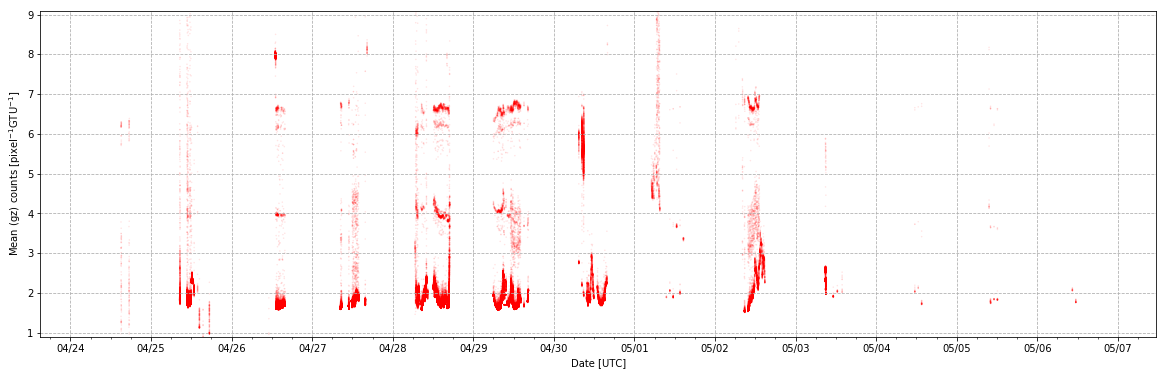

In [16]:
vis_trigger_rate(
    unl_flight_df__by_datetime['gps_datetime_min'].tolist(), 
    unl_flight_df__by_datetime['orig_mean_gz'].tolist(), 
    None,
    ax=None, show=True, ylabel='Mean (gz) counts [pixel$^{-1}$GTU$^{-1}$]',
    marker='.', alpha=.1, color='red', s=10, label=None, yscale='linear',
    ylim=(1,9)
#     ylim=(unl_flight_df__by_datetime['orig_mean_gz'].min(), 
#           unl_flight_df__by_datetime['orig_mean_gz'].quantile(q=0.997))
)

In [17]:
filename_datetime_re = re.compile(r'(\d{4})(\d\d)(\d\d)-(\d\d)(\d\d)(\d\d)-(\d+)\.(\d+)-+(LONG|CHECK)(-sqz(-dis)?)?\.root$')
    
def parse_acq_filename(infile):
    m = filename_datetime_re.search(infile)
    if m:
        bunch = int(m.group(7))
        mode = m.group(9)
        datetime_step = datetime.datetime(
            year=int(m.group(1)), month=int(m.group(2)), day=int(m.group(3)), 
            hour=int(m.group(4)), minute=int(m.group(5)), second=int(m.group(6))
        )
        step_timedelta = datetime.timedelta(seconds=0)
        if mode == 'LONG':
            step_timedelta = datetime.timedelta(seconds=120)
        elif mode == 'CHECK':
            step_timedelta = datetime.timedelta(seconds=40)
        datetime_step_modified = datetime_step + step_timedelta*(bunch-1)
        return bunch, mode, step_timedelta, datetime_step, datetime_step_modified
    return None

def count_trigger_rate_per_file_from_df(unl_flight_df, 
                                        sfa_column='source_file_acquisition', one_trg_per='packet',
                                        datetime_column='gps_datetime_min', packet_id_column='packet_id', 
                                        trg_per_frame_column='trg_size', trg_count_nonzero_column='trg_count_nonzero', 
                                       ):
    
    trigger_rate_list = []
    trigger_datetime_list = []
    
#     filename_type_re = re.compile(r'(\d+)\.(\d+)-+(LONG|CHECK)(-sqz(-dis)?)?\.root$')
    
    unl_flight_sorted_df = unl_flight_df.sort_values([sfa_column, datetime_column], ascending=[True, True])
    unl_flight_groups_df = unl_flight_sorted_df.groupby(sfa_column)

    datetime_step_high = unl_flight_sorted_df.iloc[0][datetime_column]  # generally incorrect, it will be overwritten
 
    for j, (infile, infile_group_df) in enumerate(unl_flight_groups_df):
        p = parse_acq_filename(infile)
        if not p:
            continue
        bunch, mode, step_timedelta, datetime_step, datetime_step_modified = p
        datetime_step_high = datetime_step_modified
        
    for j, (infile, infile_group_df) in enumerate(unl_flight_groups_df):
        
        print('{:d}/{:d} {}'.format(j+1, len(unl_flight_groups_df), infile))

        p = parse_acq_filename(infile)
        
        if not p:
            print(' > SKIPPING')
            continue        
        
        bunch, length, step_timedelta, datetime_step, datetime_step_modified = p
        
        if bunch < 1:
            print(' > SKIPPING (bunch < 1)')
            continue

        infile_group_sorted_df = infile_group_df #.sort_values(datetime_column, ascending=True)
                
        if datetime_step is None:
            print(' >> unable to extract datetime from filename', infile)
            continue
            
#         datetime_step_high = infile_group_df_sorted[datetime_column].iloc[0] + step_timedelta
#         last_datetime_step_start = infile_group_df_sorted[datetime_column].iloc[0]
        
        cur_trigger_num_per_step = 0
        
        if one_trg_per == 'packet':
            for packet_id, packet_group_df in infile_group_sorted_df.groupby(packet_id_column):
                cur_trigger_num_per_step += 1
        else:
            for ind, row in infile_group_sorted_df.iterrows():
                if one_trg_per == 'event':
                    cur_trigger_num_per_step += 1
                elif one_trg_per == 'frame':
                    # one trg per frame
                    cur_trigger_num_per_step += row[trg_per_frame_column]
                else:
                    cur_trigger_num_per_step += row[trg_count_nonzero_column]
                    
        trigger_rate_list.append(cur_trigger_num_per_step / step_timedelta.total_seconds())
        trigger_datetime_list.append(datetime_step_modified)
                
#                 cur_trigger_datetime_step = row[datetime_column]
                
#                 if cur_trigger_datetime_step >= datetime_step_high:
                    
#                     trigger_rate_list.append(cur_trigger_num_per_step / step_timedelta.total_seconds())
#                     trigger_datetime_list.append(last_datetime_step_start)
                    
#                     last_datetime_step_start = datetime_step_high # was cur_trigger_datetime_step 
                    
#                     num_steps = np.floor(
#                         (cur_trigger_datetime_step.total_seconds() - datetime_step_high.total_seconds()) / step_timedelta.total_seconds()
#                     )
                    
#                     datetime_step_high_calc = datetime
                    
#                     print('before while')
#                     while cur_trigger_datetime_step >= datetime_step_high:
#                         datetime_step_high += step_timedelta
#                     print('after while, datetime_step_high=',datetime_step_high, " datetime_step_high_calc=",)

                # endif
            # endfor
        # endfor
    # endfor
    
    return trigger_datetime_list, trigger_rate_list

In [18]:
trigger_datetime_list, trigger_rate_list = count_trigger_rate_per_file_from_df(unl_flight_df)

1/1038 allpackets-SPBEUSO-ACQUISITION-20170424-150143-001.001--CHECK.root
2/1038 allpackets-SPBEUSO-ACQUISITION-20170424-150228-001.001--LONG.root
3/1038 allpackets-SPBEUSO-ACQUISITION-20170424-150228-002.001--LONG.root
4/1038 allpackets-SPBEUSO-ACQUISITION-20170424-150228-003.001--LONG.root
5/1038 allpackets-SPBEUSO-ACQUISITION-20170424-150228-004.001--LONG.root
6/1038 allpackets-SPBEUSO-ACQUISITION-20170424-150228-005.001--LONG.root
7/1038 allpackets-SPBEUSO-ACQUISITION-20170424-172343-001.001--CHECK.root
8/1038 allpackets-SPBEUSO-ACQUISITION-20170424-172427-001.001--LONG.root
9/1038 allpackets-SPBEUSO-ACQUISITION-20170424-172427-002.001--LONG.root
10/1038 allpackets-SPBEUSO-ACQUISITION-20170424-172427-003.001--LONG.root
11/1038 allpackets-SPBEUSO-ACQUISITION-20170424-172427-004.001--LONG.root
12/1038 allpackets-SPBEUSO-ACQUISITION-20170424-172427-005.001--LONG.root
13/1038 allpackets-SPBEUSO-ACQUISITION-20170425-083146-001.001--CHECK.root
14/1038 allpackets-SPBEUSO-ACQUISITION-20170

112/1038 allpackets-SPBEUSO-ACQUISITION-20170427-082554-006.001--LONG-sqz.root
113/1038 allpackets-SPBEUSO-ACQUISITION-20170427-082554-007.001--LONG-sqz.root
114/1038 allpackets-SPBEUSO-ACQUISITION-20170427-082554-008.001--LONG-sqz.root
115/1038 allpackets-SPBEUSO-ACQUISITION-20170427-082554-008.001--LONG.root
116/1038 allpackets-SPBEUSO-ACQUISITION-20170427-082554-010.001--LONG-sqz.root
117/1038 allpackets-SPBEUSO-ACQUISITION-20170427-082554-010.001--LONG.root
118/1038 allpackets-SPBEUSO-ACQUISITION-20170427-082554-011.001--LONG-sqz.root
119/1038 allpackets-SPBEUSO-ACQUISITION-20170427-105115-001.001--CHECK.root
120/1038 allpackets-SPBEUSO-ACQUISITION-20170427-105159-001.001--LONG-sqz.root
121/1038 allpackets-SPBEUSO-ACQUISITION-20170427-105159-002.001--LONG-sqz.root
122/1038 allpackets-SPBEUSO-ACQUISITION-20170427-105159-003.001--LONG-sqz.root
123/1038 allpackets-SPBEUSO-ACQUISITION-20170427-105159-004.001--LONG-sqz.root
124/1038 allpackets-SPBEUSO-ACQUISITION-20170427-105159-005.001

227/1038 allpackets-SPBEUSO-ACQUISITION-20170427-125407-022.001--LONG-sqz-dis.root
228/1038 allpackets-SPBEUSO-ACQUISITION-20170427-125407-022.001--LONG-sqz.root
229/1038 allpackets-SPBEUSO-ACQUISITION-20170427-125407-023.001--LONG-sqz-dis.root
230/1038 allpackets-SPBEUSO-ACQUISITION-20170427-125407-023.001--LONG-sqz.root
231/1038 allpackets-SPBEUSO-ACQUISITION-20170427-125407-024.001--LONG-sqz-dis.root
232/1038 allpackets-SPBEUSO-ACQUISITION-20170427-125407-024.001--LONG-sqz.root
233/1038 allpackets-SPBEUSO-ACQUISITION-20170427-125407-025.001--LONG-sqz-dis.root
234/1038 allpackets-SPBEUSO-ACQUISITION-20170427-125407-025.001--LONG-sqz.root
235/1038 allpackets-SPBEUSO-ACQUISITION-20170427-125407-026.001--LONG-sqz-dis.root
236/1038 allpackets-SPBEUSO-ACQUISITION-20170427-125407-026.001--LONG-sqz.root
237/1038 allpackets-SPBEUSO-ACQUISITION-20170427-125407-027.001--LONG-sqz-dis.root
238/1038 allpackets-SPBEUSO-ACQUISITION-20170427-125407-028.001--LONG-sqz-dis.root
239/1038 allpackets-SPBE

339/1038 allpackets-SPBEUSO-ACQUISITION-20170428-130811-004.001--LONG.root
340/1038 allpackets-SPBEUSO-ACQUISITION-20170428-130811-005.001--LONG.root
341/1038 allpackets-SPBEUSO-ACQUISITION-20170428-130811-006.001--LONG.root
342/1038 allpackets-SPBEUSO-ACQUISITION-20170428-130811-007.001--LONG.root
343/1038 allpackets-SPBEUSO-ACQUISITION-20170428-130811-008.001--LONG.root
344/1038 allpackets-SPBEUSO-ACQUISITION-20170428-130811-009.001--LONG.root
345/1038 allpackets-SPBEUSO-ACQUISITION-20170428-130811-010.001--LONG.root
346/1038 allpackets-SPBEUSO-ACQUISITION-20170428-130811-011.001--LONG.root
347/1038 allpackets-SPBEUSO-ACQUISITION-20170428-130811-012.001--LONG.root
348/1038 allpackets-SPBEUSO-ACQUISITION-20170428-130811-013.001--LONG.root
349/1038 allpackets-SPBEUSO-ACQUISITION-20170428-130811-014.001--LONG.root
350/1038 allpackets-SPBEUSO-ACQUISITION-20170428-130811-015.001--LONG.root
351/1038 allpackets-SPBEUSO-ACQUISITION-20170428-130811-016.001--LONG.root
352/1038 allpackets-SPBEU

450/1038 allpackets-SPBEUSO-ACQUISITION-20170429-070031-014.001--LONG.root
451/1038 allpackets-SPBEUSO-ACQUISITION-20170429-070031-016.001--LONG.root
452/1038 allpackets-SPBEUSO-ACQUISITION-20170429-070031-017.001--LONG.root
453/1038 allpackets-SPBEUSO-ACQUISITION-20170429-070031-019.001--LONG.root
454/1038 allpackets-SPBEUSO-ACQUISITION-20170429-070031-020.001--LONG.root
455/1038 allpackets-SPBEUSO-ACQUISITION-20170429-070031-021.001--LONG.root
456/1038 allpackets-SPBEUSO-ACQUISITION-20170429-070031-025.001--LONG.root
457/1038 allpackets-SPBEUSO-ACQUISITION-20170429-070031-026.001--LONG.root
458/1038 allpackets-SPBEUSO-ACQUISITION-20170429-070031-027.001--LONG.root
459/1038 allpackets-SPBEUSO-ACQUISITION-20170429-070031-028.001--LONG.root
460/1038 allpackets-SPBEUSO-ACQUISITION-20170429-070031-029.001--LONG.root
461/1038 allpackets-SPBEUSO-ACQUISITION-20170429-070031-030.001--LONG.root
462/1038 allpackets-SPBEUSO-ACQUISITION-20170429-080051-001.001--CHECK.root
463/1038 allpackets-SPBE

562/1038 allpackets-SPBEUSO-ACQUISITION-20170429-120509-001.001--CHECK.root
563/1038 allpackets-SPBEUSO-ACQUISITION-20170429-120553-001.001--LONG-sqz.root
564/1038 allpackets-SPBEUSO-ACQUISITION-20170429-120553-002.001--LONG-sqz.root
565/1038 allpackets-SPBEUSO-ACQUISITION-20170429-120553-002.001--LONG.root
566/1038 allpackets-SPBEUSO-ACQUISITION-20170429-120553-003.001--LONG-sqz.root
567/1038 allpackets-SPBEUSO-ACQUISITION-20170429-120553-004.001--LONG-sqz.root
568/1038 allpackets-SPBEUSO-ACQUISITION-20170429-120553-005.001--LONG-sqz.root
569/1038 allpackets-SPBEUSO-ACQUISITION-20170429-120553-005.001--LONG.root
570/1038 allpackets-SPBEUSO-ACQUISITION-20170429-120553-006.001--LONG-sqz.root
571/1038 allpackets-SPBEUSO-ACQUISITION-20170429-120553-007.001--LONG-sqz.root
572/1038 allpackets-SPBEUSO-ACQUISITION-20170429-120553-008.001--LONG-sqz.root
573/1038 allpackets-SPBEUSO-ACQUISITION-20170429-120553-009.001--LONG-sqz.root
574/1038 allpackets-SPBEUSO-ACQUISITION-20170429-120553-010.001

689/1038 allpackets-SPBEUSO-ACQUISITION-20170430-105205-020.001--LONG-sqz.root
690/1038 allpackets-SPBEUSO-ACQUISITION-20170430-105205-021.001--LONG-sqz.root
691/1038 allpackets-SPBEUSO-ACQUISITION-20170430-105205-022.001--LONG-sqz.root
692/1038 allpackets-SPBEUSO-ACQUISITION-20170430-105205-023.001--LONG-sqz.root
693/1038 allpackets-SPBEUSO-ACQUISITION-20170430-105205-024.001--LONG-sqz.root
694/1038 allpackets-SPBEUSO-ACQUISITION-20170430-105205-025.001--LONG-sqz.root
695/1038 allpackets-SPBEUSO-ACQUISITION-20170430-105205-026.001--LONG-sqz.root
696/1038 allpackets-SPBEUSO-ACQUISITION-20170430-105205-027.001--LONG-sqz.root
697/1038 allpackets-SPBEUSO-ACQUISITION-20170430-105205-028.001--LONG-sqz.root
698/1038 allpackets-SPBEUSO-ACQUISITION-20170430-105205-029.001--LONG-sqz.root
699/1038 allpackets-SPBEUSO-ACQUISITION-20170430-105205-030.001--LONG-sqz.root
700/1038 allpackets-SPBEUSO-ACQUISITION-20170430-115225-001.001--CHECK.root
701/1038 allpackets-SPBEUSO-ACQUISITION-20170430-125414

825/1038 allpackets-SPBEUSO-ACQUISITION-20170501-063222-006.001--LONG-sqz.root
826/1038 allpackets-SPBEUSO-ACQUISITION-20170501-063222-007.001--LONG-sqz.root
827/1038 allpackets-SPBEUSO-ACQUISITION-20170501-063222-008.001--LONG-sqz.root
828/1038 allpackets-SPBEUSO-ACQUISITION-20170501-063222-009.001--LONG-sqz.root
829/1038 allpackets-SPBEUSO-ACQUISITION-20170501-063222-010.001--LONG-sqz.root
830/1038 allpackets-SPBEUSO-ACQUISITION-20170501-063222-011.001--LONG-sqz.root
831/1038 allpackets-SPBEUSO-ACQUISITION-20170501-063222-012.001--LONG-sqz.root
832/1038 allpackets-SPBEUSO-ACQUISITION-20170501-063222-013.001--LONG-sqz.root
833/1038 allpackets-SPBEUSO-ACQUISITION-20170501-063222-014.001--LONG-sqz.root
834/1038 allpackets-SPBEUSO-ACQUISITION-20170501-063222-015.001--LONG-sqz.root
835/1038 allpackets-SPBEUSO-ACQUISITION-20170501-063222-016.001--LONG-sqz.root
836/1038 allpackets-SPBEUSO-ACQUISITION-20170501-063222-017.001--LONG-sqz.root
837/1038 allpackets-SPBEUSO-ACQUISITION-20170501-063

938/1038 allpackets-SPBEUSO-ACQUISITION-20170502-114710-009.001--LONG-sqz.root
939/1038 allpackets-SPBEUSO-ACQUISITION-20170502-114710-010.001--LONG-sqz.root
940/1038 allpackets-SPBEUSO-ACQUISITION-20170502-114710-011.001--LONG-sqz.root
941/1038 allpackets-SPBEUSO-ACQUISITION-20170502-114710-012.001--LONG-sqz.root
942/1038 allpackets-SPBEUSO-ACQUISITION-20170502-114710-013.001--LONG-sqz.root
943/1038 allpackets-SPBEUSO-ACQUISITION-20170502-114710-014.001--LONG-sqz.root
944/1038 allpackets-SPBEUSO-ACQUISITION-20170502-114710-015.001--LONG-sqz.root
945/1038 allpackets-SPBEUSO-ACQUISITION-20170502-114710-016.001--LONG-sqz.root
946/1038 allpackets-SPBEUSO-ACQUISITION-20170502-114710-017.001--LONG-sqz.root
947/1038 allpackets-SPBEUSO-ACQUISITION-20170502-114710-018.001--LONG-sqz.root
948/1038 allpackets-SPBEUSO-ACQUISITION-20170502-114710-019.001--LONG-sqz.root
949/1038 allpackets-SPBEUSO-ACQUISITION-20170502-114710-020.001--LONG-sqz.root
950/1038 allpackets-SPBEUSO-ACQUISITION-20170502-114

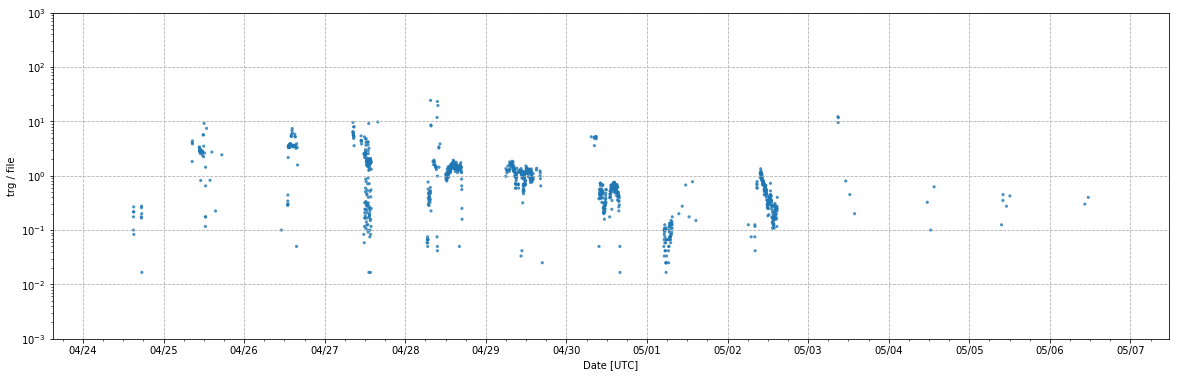

In [21]:
vis_trigger_rate(
    trigger_datetime_list, 
    trigger_rate_list, 
    None, ax=None, show=True, ylabel='trg / file',
    marker='o', alpha=.8, color=None, s=10, label=None, yscale='log',
    ylim=(10**(-2.5), 10**(2.5))
#     ylim=(unl_flight_df__by_datetime['orig_mean_gz'].min(), 
#           unl_flight_df__by_datetime['orig_mean_gz'].quantile(q=0.997))
)

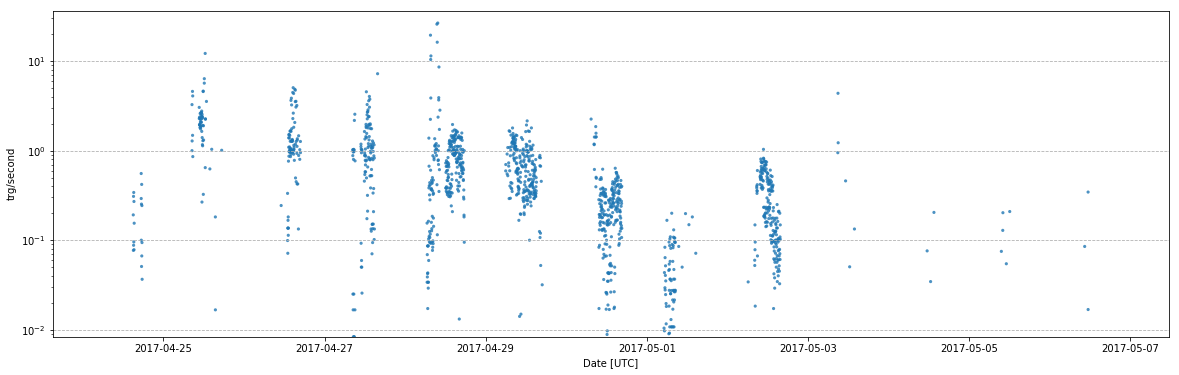

In [42]:
plt_xlim = (np.min(avg_trigger_datetime_steps_list) - datetime.timedelta(days=1), 
             np.max(avg_trigger_datetime_steps_list) + datetime.timedelta(days=1))

plt.figure(figsize=(20, 6))
plt.scatter(avg_trigger_datetime_steps_list, 
            avg_trigger_num_per_step_list, 
            s=10, alpha=.8,
#             alpha=.01,
            cmap=plt.get_cmap('plasma'),
            marker='o', edgecolors='none',
            label='Num triggers per second'
           )
plt.xlim(*plt_xlim)
plt.yscale('log')
# plt.ylim(1e-1, np.max(trigger_num_per_step)+10)
plt.ylim(np.min(avg_trigger_num_per_step_list), np.max(avg_trigger_num_per_step_list)+10)
plt.xlabel('Date [UTC]')
plt.ylabel('trg/second')
plt.gca().grid(which='major', axis='y', linestyle='--')

trigger_rate_v1_scatter_20inch_pathname = \
    os.path.join(data_snippets_dir, 'figures', 'trigger_rate_v1_scatter_20inch.png')
if not os.path.exists(trigger_num_per_second_scatter_20inch_pathname) or recreate_plots:
    plt.savefig(trigger_rate_v1_scatter_20inch_pathname, dpi=150)

plt.show()